In [1]:
try:
  import transformers

except:
  print("Installing Transformers")
  !pip -q install transformers

##Importing the Required Model

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, BertConfig
from transformers import AdamW, BertForSequenceClassification, get_linear_schedule_with_warmup
from tqdm import tqdm, trange  #for progress bars
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

##Specifying CUDA as the device

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
!nvidia-smi

Fri Sep 27 15:25:55 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8              10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

##Loading the IMDB dataset

In [4]:
df = pd.read_csv("/content/IMDB Dataset.csv", nrows = 25000)
df.shape

(25000, 2)

##Encoding the Labels

In [5]:
label_encoder = LabelEncoder()

In [6]:
df['labels'] = label_encoder.fit_transform(df['sentiment'])

In [7]:
df.sample(10)

,review,sentiment,labels
12915,"Who knew? Dowdy Queen Victoria, the plump Mona...",positive,1
7059,As long as you can suffer it! If you like watc...,negative,0
16499,After 2 years of using this site for movie rev...,positive,1
16701,Peter O'Toole gives a brilliant performance in...,positive,1
19881,"Harsh, yes, but I call 'em like I see 'em.<br ...",negative,0
18328,Here in Brazil is very rare to see a good Braz...,positive,1
22440,I felt Rancid Aluminium was a complete waste o...,negative,0
6979,"This is a pretty silly film, including what ma...",positive,1
7346,I saw this stage show when it was broadcast on...,positive,1
24674,"If anything, William Girdler was an opportunis...",positive,1


In [8]:
sentences = df.review.values

sentences = ["CLS " + sentence + " [SEP]" for sentence in sentences]
labels = df.labels.values

##Activating BERT Tokenizer

In [9]:
try:
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
    print("Tokenizer downloaded successfully.")
except Exception as e:
    print("An error occurred while downloading the tokenizer.")
    print(str(e))
    import traceback
    print(traceback.format_exc())

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Tokenizer downloaded successfully.


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [10]:
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

Tokenize the first sentence:
['cl', '##s', 'one', 'of', 'the', 'other', 'reviewers', 'has', 'mentioned', 'that', 'after', 'watching', 'just', '1', 'oz', 'episode', 'you', "'", 'll', 'be', 'hooked', '.', 'they', 'are', 'right', ',', 'as', 'this', 'is', 'exactly', 'what', 'happened', 'with', 'me', '.', '<', 'br', '/', '>', '<', 'br', '/', '>', 'the', 'first', 'thing', 'that', 'struck', 'me', 'about', 'oz', 'was', 'its', 'brutality', 'and', 'un', '##fl', '##in', '##ching', 'scenes', 'of', 'violence', ',', 'which', 'set', 'in', 'right', 'from', 'the', 'word', 'go', '.', 'trust', 'me', ',', 'this', 'is', 'not', 'a', 'show', 'for', 'the', 'faint', 'hearted', 'or', 'tim', '##id', '.', 'this', 'show', 'pulls', 'no', 'punches', 'with', 'regards', 'to', 'drugs', ',', 'sex', 'or', 'violence', '.', 'its', 'is', 'hardcore', ',', 'in', 'the', 'classic', 'use', 'of', 'the', 'word', '.', '<', 'br', '/', '>', '<', 'br', '/', '>', 'it', 'is', 'called', 'oz', 'as', 'that', 'is', 'the', 'nickname', 'given

##Preprocessing the data

In [11]:
MAX_LEN = 128

input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

##Creating Attention Masks

In [12]:
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

##Splitting the data intro training and validation datasets

In [13]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels,
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

##Converting all the data into tensors

In [14]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

##Creating an Iterator

In [15]:
batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

##Model Configuration

In [16]:
from transformers import BertModel, BertConfig
configuration = BertConfig()

model = BertModel(configuration)

configuration = model.config
print(configuration)

BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.44.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



##Loading the Hugging Face BERT uncased base model

In [17]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model = nn.DataParallel(model)
model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DataParallel(
  (module): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSdpaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=7

##Optimizer Parameters

In [18]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.weight']

optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.1},

    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [19]:
layer_parameters = [p for n, p in model.named_parameters() if 'layer.3' in n]
print(layer_parameters)

[Parameter containing:
tensor([[ 0.0586, -0.0279,  0.0022,  ..., -0.0205,  0.0419,  0.0560],
        [-0.0011,  0.1283, -0.0564,  ..., -0.0514, -0.0199,  0.0516],
        [-0.0083,  0.0060, -0.0469,  ...,  0.0569, -0.0073, -0.0616],
        ...,
        [ 0.0118,  0.0645, -0.0159,  ..., -0.0027, -0.0031, -0.0141],
        [ 0.0029,  0.0531,  0.0221,  ..., -0.0047,  0.0399,  0.0344],
        [ 0.0512,  0.0246,  0.0077,  ...,  0.0108,  0.0262,  0.0081]],
       device='cuda:0', requires_grad=True), Parameter containing:
tensor([ 9.7401e-02, -1.9291e-01,  4.3323e-02,  1.7938e-01, -8.0236e-02,
         2.4005e-01, -1.1202e-01, -7.8751e-02,  1.3820e-01, -2.4162e-01,
         1.9788e-01, -3.2046e-01,  3.5266e-02,  5.7152e-01, -5.9514e-02,
        -2.5558e-02,  9.7958e-02, -4.7495e-02, -2.0452e-01,  3.0384e-04,
         3.0269e-01,  4.9826e-02, -2.9197e-02,  2.3859e-01,  1.9353e-01,
         1.0818e-01,  2.7912e-01,  6.2726e-02, -1.7285e-01,  4.8728e-02,
         1.9279e-02, -6.0480e-01,  3.9

In [20]:
no_decay

['bias', 'LayerNorm.weight']

In [21]:
small_sample = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)][:2],
     'weight_decay_rate': 0.1},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)][:2],
     'weight_decay_rate': 0.0}
]

for i, group in enumerate(small_sample):
    print(f"Group {i+1}:")
    print(f"Weight decay rate: {group['weight_decay_rate']}")
    for j, param in enumerate(group['params']):
        print(f"Parameter {j+1}: {param}")

Group 1:
Weight decay rate: 0.1
Parameter 1: Parameter containing:
tensor([[-0.0102, -0.0615, -0.0265,  ..., -0.0199, -0.0372, -0.0098],
        [-0.0117, -0.0600, -0.0323,  ..., -0.0168, -0.0401, -0.0107],
        [-0.0198, -0.0627, -0.0326,  ..., -0.0165, -0.0420, -0.0032],
        ...,
        [-0.0218, -0.0556, -0.0135,  ..., -0.0043, -0.0151, -0.0249],
        [-0.0462, -0.0565, -0.0019,  ...,  0.0157, -0.0139, -0.0095],
        [ 0.0015, -0.0821, -0.0160,  ..., -0.0081, -0.0475,  0.0753]],
       device='cuda:0', requires_grad=True)
Parameter 2: Parameter containing:
tensor([[ 1.7505e-02, -2.5631e-02, -3.6642e-02,  ...,  3.3437e-05,
          6.8312e-04,  1.5441e-02],
        [ 7.7580e-03,  2.2613e-03, -1.9444e-02,  ...,  2.8910e-02,
          2.9753e-02, -5.3247e-03],
        [-1.1287e-02, -1.9644e-03, -1.1573e-02,  ...,  1.4908e-02,
          1.8741e-02, -7.3140e-03],
        ...,
        [ 1.7418e-02,  3.4903e-03, -9.5621e-03,  ...,  2.9599e-03,
          4.3435e-04, -2.6949e-

##Hyperparameters

In [22]:
epochs = 4

optimizer = AdamW(optimizer_grouped_parameters,
                  lr = 2e-5,
                  eps = 1e-8
                  )

total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


##Accuracy Function

In [23]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

##Training Loop

In [24]:
train_loss_set = []

for _ in trange(epochs, desc="Epoch"):

  model.train()

  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0

  for step, batch in enumerate(train_dataloader):
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    optimizer.zero_grad()
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    loss = outputs['loss']
    train_loss_set.append(loss.item())
    loss.backward()
    optimizer.step()

    scheduler.step()

    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))


  model.eval()

  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  for batch in validation_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    logits = logits['logits'].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)

    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 0.3581510009667413


Epoch:  25%|██▌       | 1/4 [07:31<22:33, 451.32s/it]

Validation Accuracy: 0.8876582278481012
Train loss: 0.21816900389438326


Epoch:  50%|█████     | 2/4 [15:14<15:16, 458.24s/it]

Validation Accuracy: 0.8920094936708861
Train loss: 0.13051595018425194


Epoch:  75%|███████▌  | 3/4 [22:57<07:40, 460.51s/it]

Validation Accuracy: 0.8951740506329114
Train loss: 0.07249465107253689


Epoch: 100%|██████████| 4/4 [30:40<00:00, 460.02s/it]

Validation Accuracy: 0.8955696202531646


##Training Evaluation

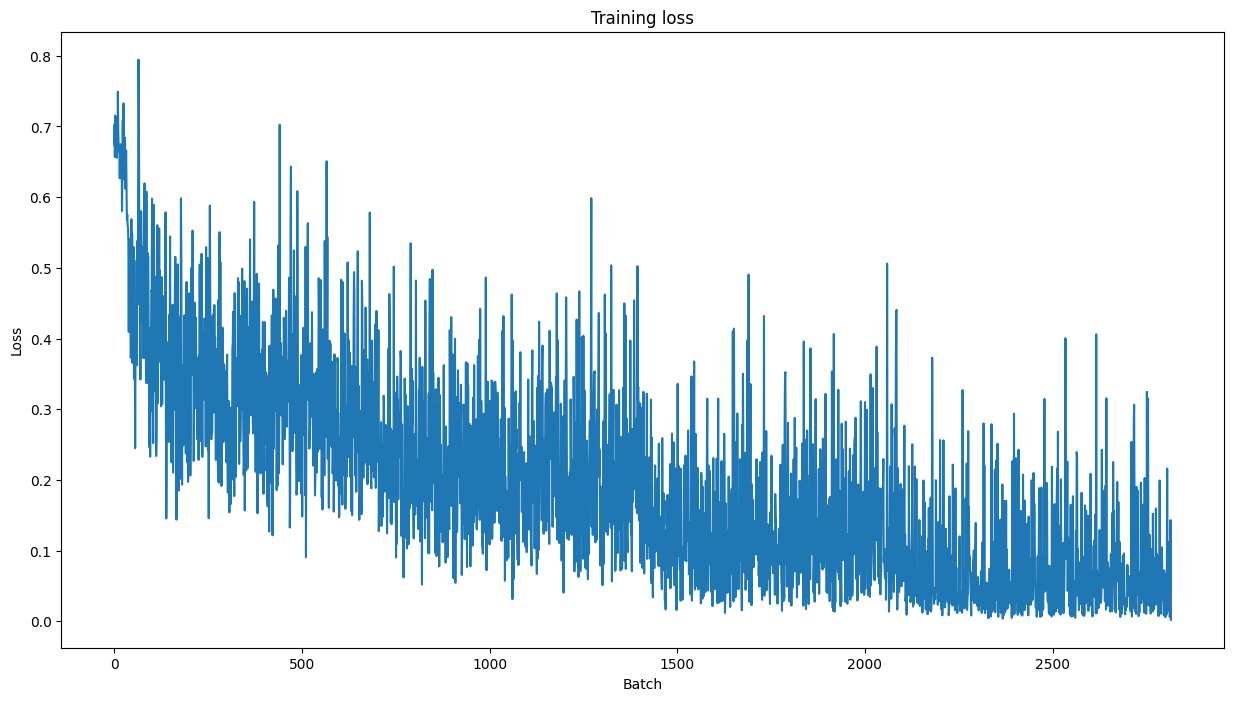

In [25]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

##Saving the Model

In [26]:
save_directory = "/content/model"

if isinstance(model, torch.nn.DataParallel):
    model.module.save_pretrained(save_directory)
else:
    model.save_pretrained(save_directory)

tokenizer.save_pretrained(save_directory)

('/content/model/tokenizer_config.json',
 '/content/model/special_tokens_map.json',
 '/content/model/vocab.txt',
 '/content/model/added_tokens.json')

##Creating an interface for the model

In [27]:
from google.colab import drive
drive.mount('/content/drive')

!mkdir -p /content/model/model/

! cp drive/MyDrive/files/model_C5/*.* /content/model

!pip install Transformers

from transformers import BertTokenizer, BertForSequenceClassification

load_directory = "/content/model/"

model = BertForSequenceClassification.from_pretrained(load_directory)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Mounted at /content/drive
cp: cannot stat 'drive/MyDrive/files/model_C5/*.*': No such file or directory


In [28]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

##Prediction Function

In [30]:
def predict(sentence, model, tokenizer):
    sentence = "[CLS] " + sentence + " [SEP]"
    tokenized_text = tokenizer.tokenize(sentence)

    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    segments_ids = [0] * len(tokenized_text)

    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])

    with torch.no_grad():
        outputs = model(tokens_tensor, token_type_ids=segments_tensors)
        logits = outputs.logits
        predicted_label = torch.argmax(logits, dim=1).item()

    return predicted_label

##Interacting with the model

In [33]:
!pip -q install ipywidgets

In [32]:
import ipywidgets as widgets
from IPython.display import display

def model_predict_interface(sentence):
    prediction = predict(sentence, model, tokenizer)
    if prediction == 0:
        return "Negative Sentiment"
    elif prediction == 1:
        return "Positive Sentiment"
    else:
        return f"Label: {prediction}"

text_input = widgets.Textarea(
    placeholder='Type something',
    description='Sentence:',
    disabled=False,
    layout=widgets.Layout(width='100%', height='50px')
)

output_label = widgets.Label(
    value='',
    layout=widgets.Layout(width='100%', height='25px'),
    style={'description_width': 'initial'}
)

def on_text_submit(change):
    output_label.value = model_predict_interface(change.new)

text_input.observe(on_text_submit, names='value')

display(text_input, output_label)

Textarea(value='', description='Sentence:', layout=Layout(height='50px', width='100%'), placeholder='Type some…

Label(value='', layout=Layout(height='25px', width='100%'), style=DescriptionStyle(description_width='initial'…